In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\pravi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Track generation: 1076..1349 -> 273-tiles track


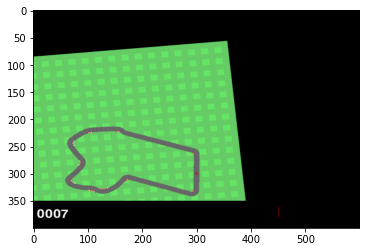


action ['+0.00', '+0.00', '+0.00']
step 0 total_reward +7.25


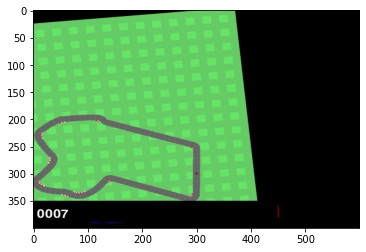

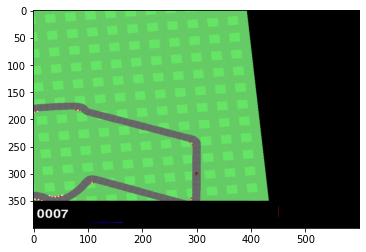

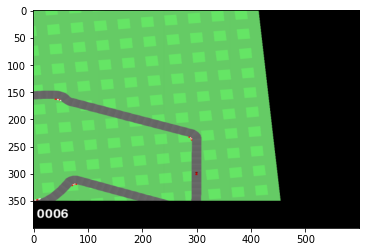

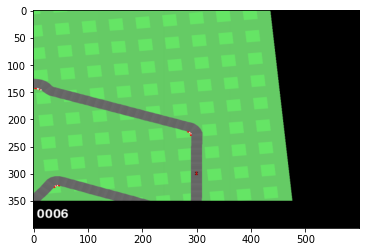

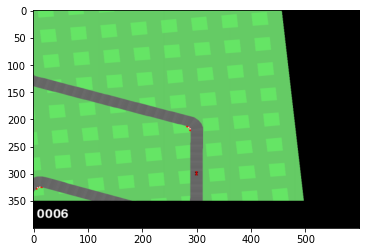

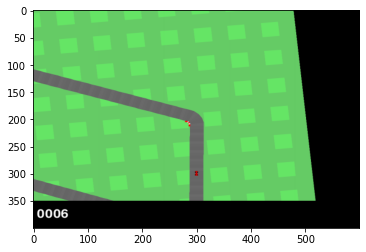

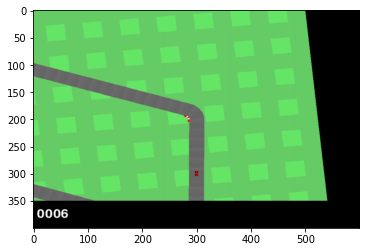

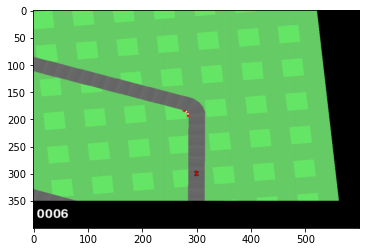

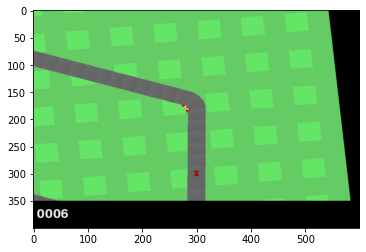

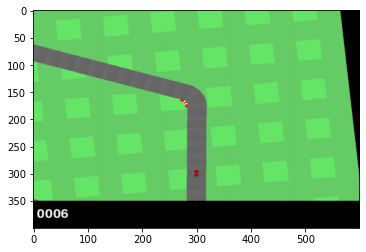

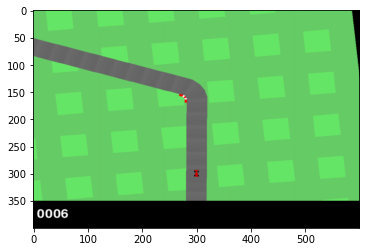

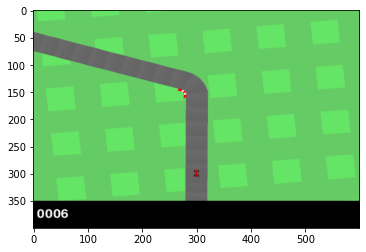

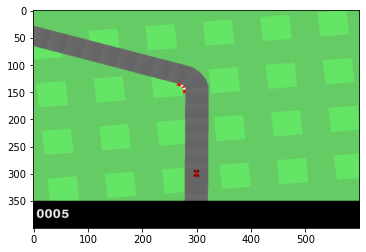

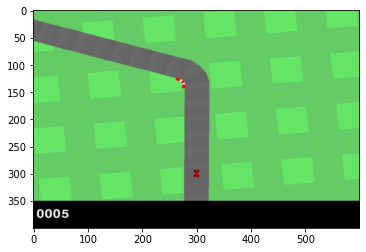

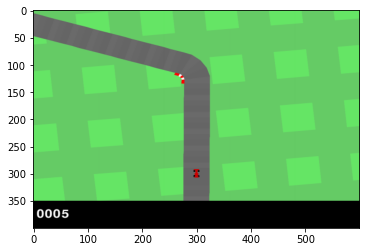

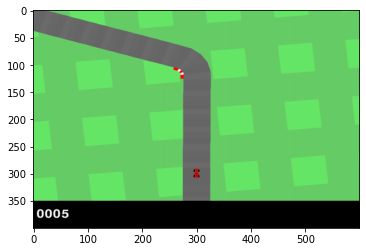

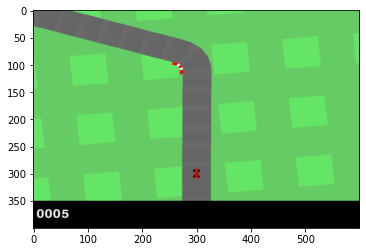

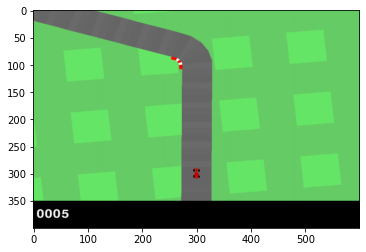

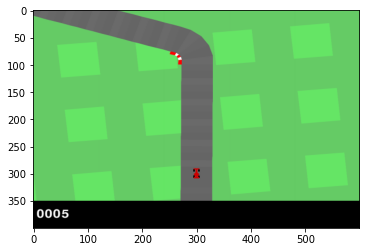

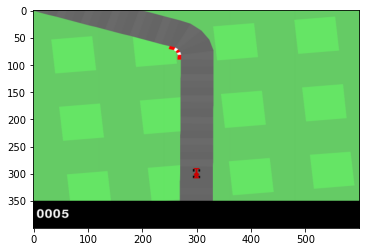

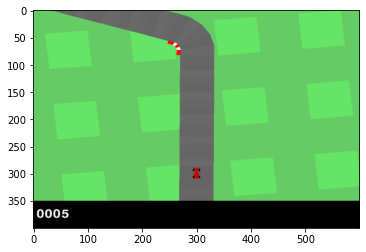

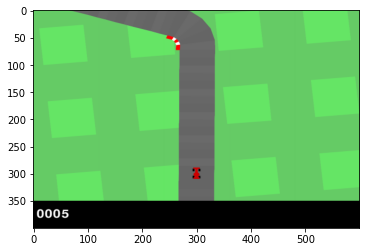

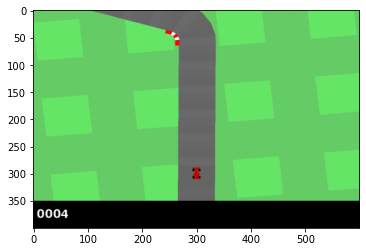

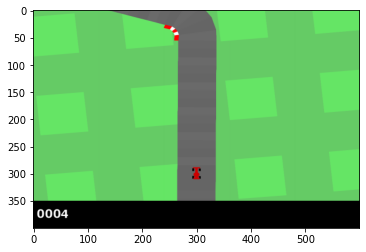

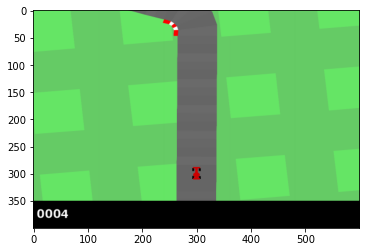

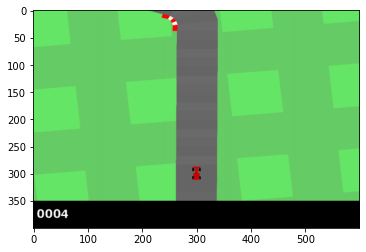

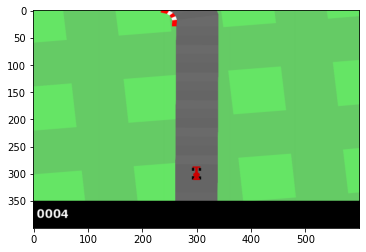

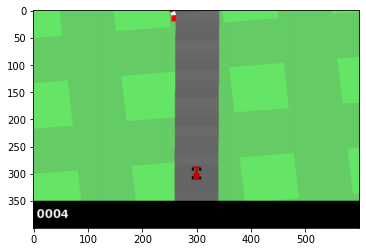

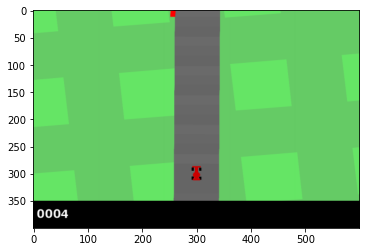

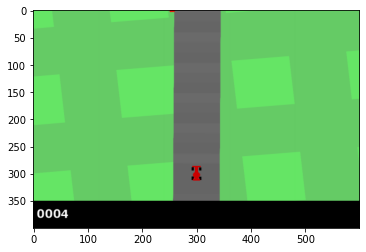

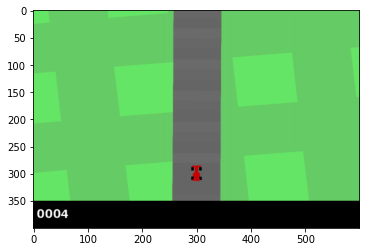

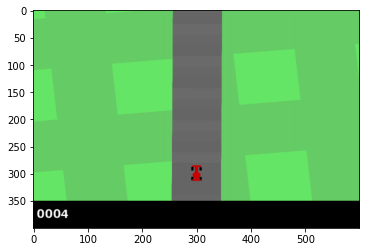

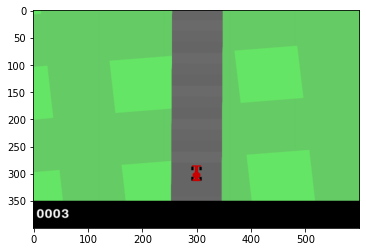

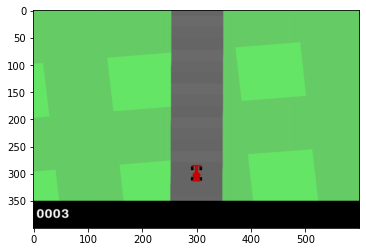

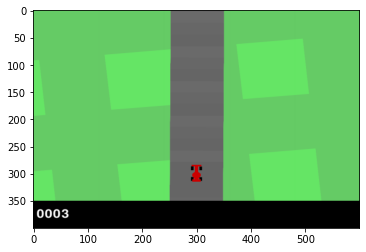

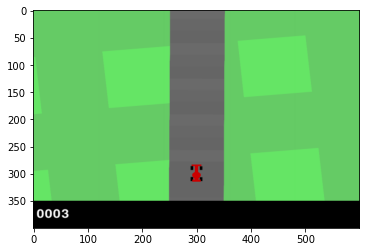

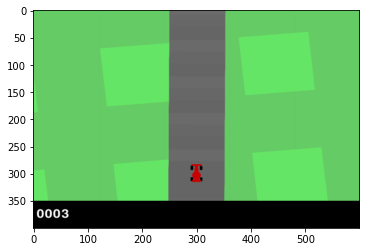

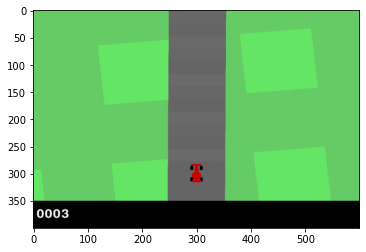

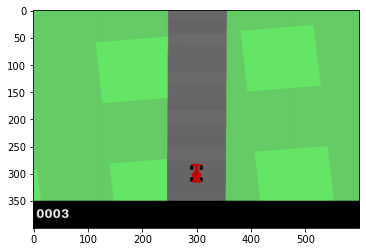

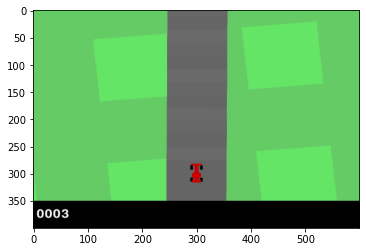

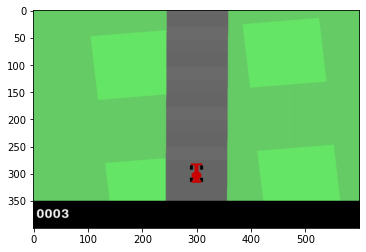

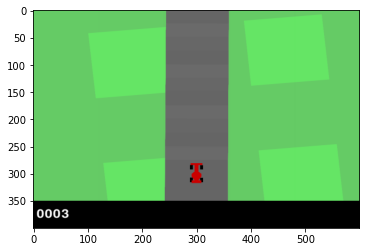

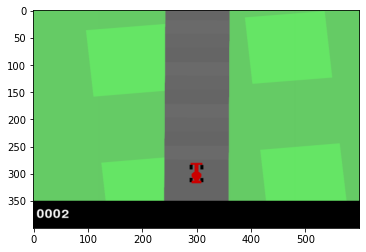

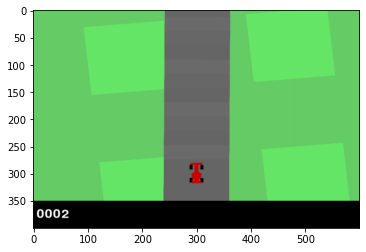

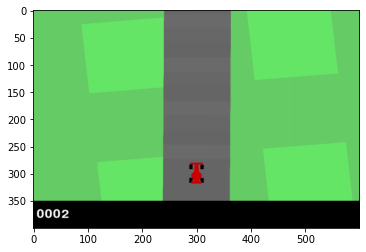

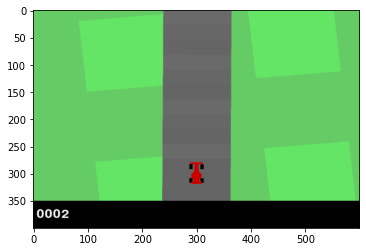

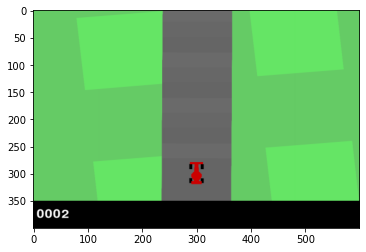

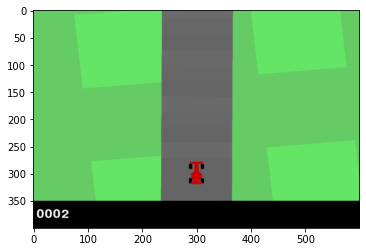

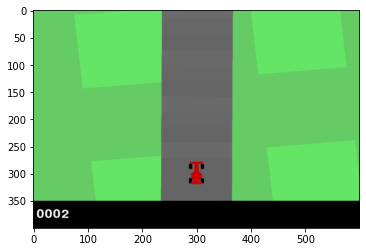

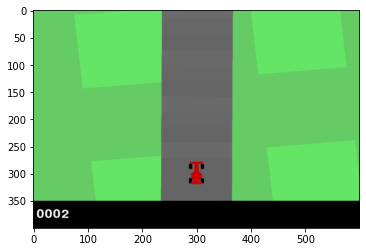

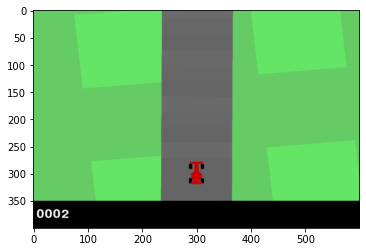

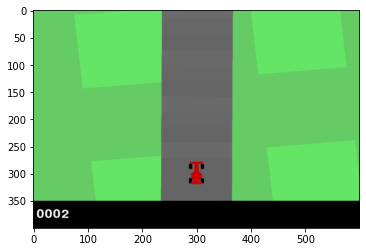

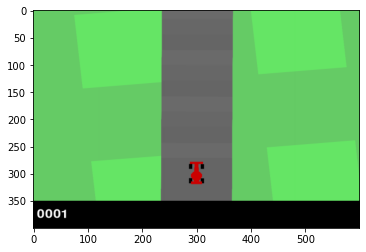

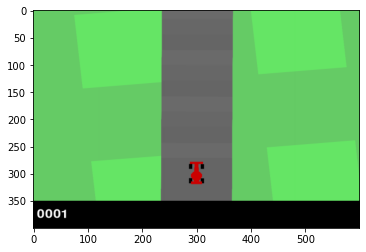

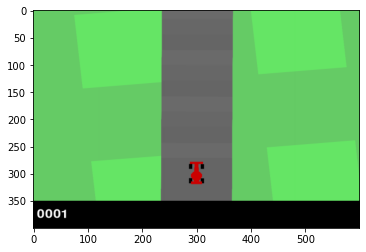

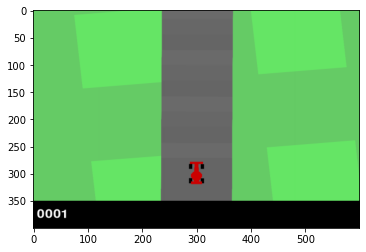

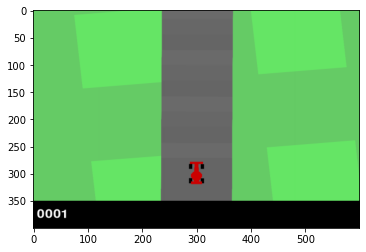

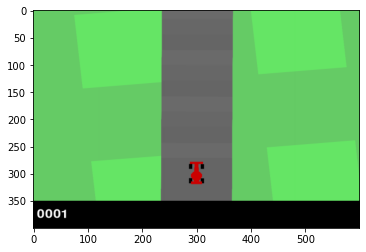

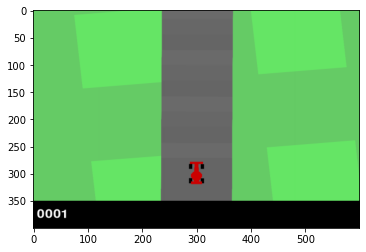

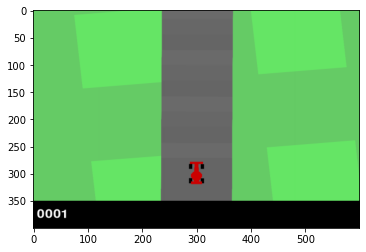

KeyboardInterrupt: 

In [2]:
__credits__ = ["Andrea PIERRÉ"]

import math
import sys
from typing import Optional

import Box2D
import numpy as np
from Box2D.b2 import contactListener, fixtureDef, polygonShape

import gym
from gym import spaces
from gym.envs.box2d.car_dynamics import Car
from gym.utils import EzPickle, seeding

STATE_W = 96  # less than Atari 160x192
STATE_H = 96
VIDEO_W = 600
VIDEO_H = 400
WINDOW_W = 1000
WINDOW_H = 800

SCALE = 6.0  # Track scale
TRACK_RAD = 900 / SCALE  # Track is heavily morphed circle with this radius
PLAYFIELD = 2000 / SCALE  # Game over boundary
FPS = 50  # Frames per second
ZOOM = 2.7  # Camera zoom
ZOOM_FOLLOW = True  # Set to False for fixed view (don't use zoom)


TRACK_DETAIL_STEP = 21 / SCALE
TRACK_TURN_RATE = 0.31
TRACK_WIDTH = 40 / SCALE
BORDER = 8 / SCALE
BORDER_MIN_COUNT = 4

ROAD_COLOR = [0.4, 0.4, 0.4]


class FrictionDetector(contactListener):
    def __init__(self, env, lap_complete_percent):
        contactListener.__init__(self)
        self.env = env
        self.lap_complete_percent = lap_complete_percent

    def BeginContact(self, contact):
        self._contact(contact, True)

    def EndContact(self, contact):
        self._contact(contact, False)

    def _contact(self, contact, begin):
        tile = None
        obj = None
        u1 = contact.fixtureA.body.userData
        u2 = contact.fixtureB.body.userData
        if u1 and "road_friction" in u1.__dict__:
            tile = u1
            obj = u2
        if u2 and "road_friction" in u2.__dict__:
            tile = u2
            obj = u1
        if not tile:
            return

        tile.color[0] = ROAD_COLOR[0]
        tile.color[1] = ROAD_COLOR[1]
        tile.color[2] = ROAD_COLOR[2]
        if not obj or "tiles" not in obj.__dict__:
            return
        if begin:
            obj.tiles.add(tile)
            if not tile.road_visited:
                tile.road_visited = True
                self.env.reward += 1000.0 / len(self.env.track)
                self.env.tile_visited_count += 1

                # Lap is considered completed if enough % of the track was covered
                if (
                    tile.idx == 0
                    and self.env.tile_visited_count / len(self.env.track)
                    > self.lap_complete_percent
                ):
                    self.env_new_lap = True
        else:
            obj.tiles.remove(tile)


class CarRacing(gym.Env, EzPickle):
    """
    ### Description
    The easiest continuous control task to learn from pixels - a top-down
    racing environment. Discrete control is reasonable in this environment as
    well; on/off discretization is fine.
    The game is solved when the agent consistently gets 900+ points.
    The generated track is random every episode.
    Some indicators are shown at the bottom of the window along with the
    state RGB buffer. From left to right: true speed, four ABS sensors,
    steering wheel position, and gyroscope.
    To play yourself (it's rather fast for humans), type:
    ```
    python gym/envs/box2d/car_racing.py
    ```
    Remember: it's a powerful rear-wheel drive car - don't press the accelerator
    and turn at the same time.
    ### Action Space
    There are 3 actions: steering (-1 is full left, +1 is full right), gas,
    and breaking.
    ### Observation Space
    State consists of 96x96 pixels.
    ### Rewards
    The reward is -0.1 every frame and +1000/N for every track tile visited,
    where N is the total number of tiles visited in the track. For example,
    if you have finished in 732 frames, your reward is
    1000 - 0.1*732 = 926.8 points.
    ### Starting State
    The car starts at rest in the center of the road.
    ### Episode Termination
    The episode finishes when all of the tiles are visited. The car can also go
    outside of the playfield - that is, far off the track, in which case it will
    receive -100 reward and die.
    ### Arguments
    There are no arguments supported in constructing the environment.
    ### Version History
    - v0: Current version
    ### References
    - Chris Campbell (2014), http://www.iforce2d.net/b2dtut/top-down-car.
    ### Credits
    Created by Oleg Klimov
    """

    metadata = {
        "render_modes": ["human", "rgb_array", "state_pixels"],
        "render_fps": FPS,
    }

    def __init__(self, verbose=1, lap_complete_percent=0.95):
        EzPickle.__init__(self)
        self.contactListener_keepref = FrictionDetector(self, lap_complete_percent)
        self.world = Box2D.b2World((0, 0), contactListener=self.contactListener_keepref)
        self.screen = None
        self.clock = None
        self.isopen = True
        self.invisible_state_window = None
        self.invisible_video_window = None
        self.road = None
        self.car = None
        self.reward = 0.0
        self.prev_reward = 0.0
        self.verbose = verbose
        self.new_lap = False
        self.fd_tile = fixtureDef(
            shape=polygonShape(vertices=[(0, 0), (1, 0), (1, -1), (0, -1)])
        )

        # This will throw a warning in tests/envs/test_envs in utils/env_checker.py as the space is not symmetric
        #   or normalised however this is not possible here so ignore
        self.action_space = spaces.Box(
            np.array([-1, 0, 0]).astype(np.float32),
            np.array([+1, +1, +1]).astype(np.float32),
        )  # steer, gas, brake

        self.observation_space = spaces.Box(
            low=0, high=255, shape=(STATE_H, STATE_W, 3), dtype=np.uint8
        )

    def _destroy(self):
        if not self.road:
            return
        for t in self.road:
            self.world.DestroyBody(t)
        self.road = []
        self.car.destroy()

    def _create_track(self):
        CHECKPOINTS = 12

        # Create checkpoints
        checkpoints = []
        for c in range(CHECKPOINTS):
            noise = self.np_random.uniform(0, 2 * math.pi * 1 / CHECKPOINTS)
            alpha = 2 * math.pi * c / CHECKPOINTS + noise
            rad = self.np_random.uniform(TRACK_RAD / 3, TRACK_RAD)

            if c == 0:
                alpha = 0
                rad = 1.5 * TRACK_RAD
            if c == CHECKPOINTS - 1:
                alpha = 2 * math.pi * c / CHECKPOINTS
                self.start_alpha = 2 * math.pi * (-0.5) / CHECKPOINTS
                rad = 1.5 * TRACK_RAD

            checkpoints.append((alpha, rad * math.cos(alpha), rad * math.sin(alpha)))
        self.road = []

        # Go from one checkpoint to another to create track
        x, y, beta = 1.5 * TRACK_RAD, 0, 0
        dest_i = 0
        laps = 0
        track = []
        no_freeze = 2500
        visited_other_side = False
        while True:
            alpha = math.atan2(y, x)
            if visited_other_side and alpha > 0:
                laps += 1
                visited_other_side = False
            if alpha < 0:
                visited_other_side = True
                alpha += 2 * math.pi

            while True:  # Find destination from checkpoints
                failed = True

                while True:
                    dest_alpha, dest_x, dest_y = checkpoints[dest_i % len(checkpoints)]
                    if alpha <= dest_alpha:
                        failed = False
                        break
                    dest_i += 1
                    if dest_i % len(checkpoints) == 0:
                        break

                if not failed:
                    break

                alpha -= 2 * math.pi
                continue

            r1x = math.cos(beta)
            r1y = math.sin(beta)
            p1x = -r1y
            p1y = r1x
            dest_dx = dest_x - x  # vector towards destination
            dest_dy = dest_y - y
            # destination vector projected on rad:
            proj = r1x * dest_dx + r1y * dest_dy
            while beta - alpha > 1.5 * math.pi:
                beta -= 2 * math.pi
            while beta - alpha < -1.5 * math.pi:
                beta += 2 * math.pi
            prev_beta = beta
            proj *= SCALE
            if proj > 0.3:
                beta -= min(TRACK_TURN_RATE, abs(0.001 * proj))
            if proj < -0.3:
                beta += min(TRACK_TURN_RATE, abs(0.001 * proj))
            x += p1x * TRACK_DETAIL_STEP
            y += p1y * TRACK_DETAIL_STEP
            track.append((alpha, prev_beta * 0.5 + beta * 0.5, x, y))
            if laps > 4:
                break
            no_freeze -= 1
            if no_freeze == 0:
                break

        # Find closed loop range i1..i2, first loop should be ignored, second is OK
        i1, i2 = -1, -1
        i = len(track)
        while True:
            i -= 1
            if i == 0:
                return False  # Failed
            pass_through_start = (
                track[i][0] > self.start_alpha and track[i - 1][0] <= self.start_alpha
            )
            if pass_through_start and i2 == -1:
                i2 = i
            elif pass_through_start and i1 == -1:
                i1 = i
                break
        if self.verbose == 1:
            print("Track generation: %i..%i -> %i-tiles track" % (i1, i2, i2 - i1))
        assert i1 != -1
        assert i2 != -1

        track = track[i1 : i2 - 1]

        first_beta = track[0][1]
        first_perp_x = math.cos(first_beta)
        first_perp_y = math.sin(first_beta)
        # Length of perpendicular jump to put together head and tail
        well_glued_together = np.sqrt(
            np.square(first_perp_x * (track[0][2] - track[-1][2]))
            + np.square(first_perp_y * (track[0][3] - track[-1][3]))
        )
        if well_glued_together > TRACK_DETAIL_STEP:
            return False

        # Red-white border on hard turns
        border = [False] * len(track)
        for i in range(len(track)):
            good = True
            oneside = 0
            for neg in range(BORDER_MIN_COUNT):
                beta1 = track[i - neg - 0][1]
                beta2 = track[i - neg - 1][1]
                good &= abs(beta1 - beta2) > TRACK_TURN_RATE * 0.2
                oneside += np.sign(beta1 - beta2)
            good &= abs(oneside) == BORDER_MIN_COUNT
            border[i] = good
        for i in range(len(track)):
            for neg in range(BORDER_MIN_COUNT):
                border[i - neg] |= border[i]

        # Create tiles
        for i in range(len(track)):
            alpha1, beta1, x1, y1 = track[i]
            alpha2, beta2, x2, y2 = track[i - 1]
            road1_l = (
                x1 - TRACK_WIDTH * math.cos(beta1),
                y1 - TRACK_WIDTH * math.sin(beta1),
            )
            road1_r = (
                x1 + TRACK_WIDTH * math.cos(beta1),
                y1 + TRACK_WIDTH * math.sin(beta1),
            )
            road2_l = (
                x2 - TRACK_WIDTH * math.cos(beta2),
                y2 - TRACK_WIDTH * math.sin(beta2),
            )
            road2_r = (
                x2 + TRACK_WIDTH * math.cos(beta2),
                y2 + TRACK_WIDTH * math.sin(beta2),
            )
            vertices = [road1_l, road1_r, road2_r, road2_l]
            self.fd_tile.shape.vertices = vertices
            t = self.world.CreateStaticBody(fixtures=self.fd_tile)
            t.userData = t
            c = 0.01 * (i % 3)
            t.color = [ROAD_COLOR[0] + c, ROAD_COLOR[1] + c, ROAD_COLOR[2] + c]
            t.road_visited = False
            t.road_friction = 1.0
            t.idx = i
            t.fixtures[0].sensor = True
            self.road_poly.append(([road1_l, road1_r, road2_r, road2_l], t.color))
            self.road.append(t)
            if border[i]:
                side = np.sign(beta2 - beta1)
                b1_l = (
                    x1 + side * TRACK_WIDTH * math.cos(beta1),
                    y1 + side * TRACK_WIDTH * math.sin(beta1),
                )
                b1_r = (
                    x1 + side * (TRACK_WIDTH + BORDER) * math.cos(beta1),
                    y1 + side * (TRACK_WIDTH + BORDER) * math.sin(beta1),
                )
                b2_l = (
                    x2 + side * TRACK_WIDTH * math.cos(beta2),
                    y2 + side * TRACK_WIDTH * math.sin(beta2),
                )
                b2_r = (
                    x2 + side * (TRACK_WIDTH + BORDER) * math.cos(beta2),
                    y2 + side * (TRACK_WIDTH + BORDER) * math.sin(beta2),
                )
                self.road_poly.append(
                    ([b1_l, b1_r, b2_r, b2_l], (1, 1, 1) if i % 2 == 0 else (1, 0, 0))
                )
        self.track = track
        return True

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        return_info: bool = False,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.reward = 0.0
        self.prev_reward = 0.0
        self.tile_visited_count = 0
        self.t = 0.0
        self.new_lap = False
        self.road_poly = []

        while True:
            success = self._create_track()
            if success:
                break
            if self.verbose == 1:
                print(
                    "retry to generate track (normal if there are not many"
                    "instances of this message)"
                )
        self.car = Car(self.world, *self.track[0][1:4])

        if not return_info:
            return self.step(None)[0]
        else:
            return self.step(None)[0], {}

    def step(self, action):
        if action is not None:
            self.car.steer(-action[0])
            self.car.gas(action[1])
            self.car.brake(action[2])

        self.car.step(1.0 / FPS)
        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)
        self.t += 1.0 / FPS

        self.state = self.render("state_pixels")

        step_reward = 0
        done = False
        if action is not None:  # First step without action, called from reset()
            self.reward -= 0.1
            # We actually don't want to count fuel spent, we want car to be faster.
            # self.reward -=  10 * self.car.fuel_spent / ENGINE_POWER
            self.car.fuel_spent = 0.0
            step_reward = self.reward - self.prev_reward
            self.prev_reward = self.reward
            if self.tile_visited_count == len(self.track) or self.new_lap:
                done = True
            x, y = self.car.hull.position
            if abs(x) > PLAYFIELD or abs(y) > PLAYFIELD:
                done = True
                step_reward = -100

        return self.state, step_reward, done, {}

    def render(self, mode="human"):
        import pygame

        pygame.font.init()

        assert mode in ["human", "state_pixels", "rgb_array"]
        if self.screen is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((WINDOW_W, WINDOW_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        if "t" not in self.__dict__:
            return  # reset() not called yet

        self.surf = pygame.Surface((WINDOW_W, WINDOW_H))

        # computing transformations
        angle = -self.car.hull.angle
        # Animating first second zoom.
        zoom = 0.1 * SCALE * max(1 - self.t, 0) + ZOOM * SCALE * min(self.t, 1)
        scroll_x = -(self.car.hull.position[0] + PLAYFIELD) * zoom
        scroll_y = -(self.car.hull.position[1] + PLAYFIELD) * zoom
        trans = pygame.math.Vector2((scroll_x, scroll_y)).rotate_rad(angle)
        trans = (WINDOW_W / 2 + trans[0], WINDOW_H / 4 + trans[1])

        self.render_road(zoom, trans, angle)
        self.car.draw(self.surf, zoom, trans, angle, mode != "state_pixels")

        self.surf = pygame.transform.flip(self.surf, False, True)

        # showing stats
        self.render_indicators(WINDOW_W, WINDOW_H)

        font = pygame.font.Font(pygame.font.get_default_font(), 42)
        text = font.render("%04i" % self.reward, True, (255, 255, 255), (0, 0, 0))
        text_rect = text.get_rect()
        text_rect.center = (60, WINDOW_H - WINDOW_H * 2.5 / 40.0)
        self.surf.blit(text, text_rect)

        if mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            self.screen.fill(0)
            self.screen.blit(self.surf, (0, 0))
            pygame.display.flip()

        if mode == "rgb_array":
            return self._create_image_array(self.surf, (VIDEO_W, VIDEO_H))
        elif mode == "state_pixels":
            return self._create_image_array(self.surf, (STATE_W, STATE_H))
        else:
            return self.isopen

    def render_road(self, zoom, translation, angle):
        bounds = PLAYFIELD
        field = [
            (2 * bounds, 2 * bounds),
            (2 * bounds, 0),
            (0, 0),
            (0, 2 * bounds),
        ]
        trans_field = []
        self.draw_colored_polygon(
            self.surf, field, (102, 204, 102), zoom, translation, angle
        )

        k = bounds / (20.0)
        grass = []
        for x in range(0, 40, 2):
            for y in range(0, 40, 2):
                grass.append(
                    [
                        (k * x + k, k * y + 0),
                        (k * x + 0, k * y + 0),
                        (k * x + 0, k * y + k),
                        (k * x + k, k * y + k),
                    ]
                )
        for poly in grass:
            self.draw_colored_polygon(
                self.surf, poly, (102, 230, 102), zoom, translation, angle
            )

        for poly, color in self.road_poly:
            # converting to pixel coordinates
            poly = [(p[0] + PLAYFIELD, p[1] + PLAYFIELD) for p in poly]
            color = [int(c * 255) for c in color]
            self.draw_colored_polygon(self.surf, poly, color, zoom, translation, angle)

    def render_indicators(self, W, H):
        import pygame

        s = W / 40.0
        h = H / 40.0
        color = (0, 0, 0)
        polygon = [(W, H), (W, H - 5 * h), (0, H - 5 * h), (0, H)]
        pygame.draw.polygon(self.surf, color=color, points=polygon)

        def vertical_ind(place, val):
            return [
                (place * s, H - (h + h * val)),
                ((place + 1) * s, H - (h + h * val)),
                ((place + 1) * s, H - h),
                ((place + 0) * s, H - h),
            ]

        def horiz_ind(place, val):
            return [
                ((place + 0) * s, H - 4 * h),
                ((place + val) * s, H - 4 * h),
                ((place + val) * s, H - 2 * h),
                ((place + 0) * s, H - 2 * h),
            ]

        true_speed = np.sqrt(
            np.square(self.car.hull.linearVelocity[0])
            + np.square(self.car.hull.linearVelocity[1])
        )

        # simple wrapper to render if the indicator value is above a threshold
        def render_if_min(value, points, color):
            if abs(value) > 1e-4:
                pygame.draw.polygon(self.surf, points=points, color=color)

        render_if_min(true_speed, vertical_ind(5, 0.02 * true_speed), (255, 255, 255))
        # ABS sensors
        render_if_min(
            self.car.wheels[0].omega,
            vertical_ind(7, 0.01 * self.car.wheels[0].omega),
            (0, 0, 255),
        )
        render_if_min(
            self.car.wheels[1].omega,
            vertical_ind(8, 0.01 * self.car.wheels[1].omega),
            (0, 0, 255),
        )
        render_if_min(
            self.car.wheels[2].omega,
            vertical_ind(9, 0.01 * self.car.wheels[2].omega),
            (51, 0, 255),
        )
        render_if_min(
            self.car.wheels[3].omega,
            vertical_ind(10, 0.01 * self.car.wheels[3].omega),
            (51, 0, 255),
        )

        render_if_min(
            self.car.wheels[0].joint.angle,
            horiz_ind(20, -10.0 * self.car.wheels[0].joint.angle),
            (0, 255, 0),
        )
        render_if_min(
            self.car.hull.angularVelocity,
            horiz_ind(30, -0.8 * self.car.hull.angularVelocity),
            (255, 0, 0),
        )

    def draw_colored_polygon(self, surface, poly, color, zoom, translation, angle):
        import pygame
        from pygame import gfxdraw

        poly = [pygame.math.Vector2(c).rotate_rad(angle) for c in poly]
        poly = [
            (c[0] * zoom + translation[0], c[1] * zoom + translation[1]) for c in poly
        ]
        gfxdraw.aapolygon(self.surf, poly, color)
        gfxdraw.filled_polygon(self.surf, poly, color)

    def _create_image_array(self, screen, size):
        import pygame

        scaled_screen = pygame.transform.smoothscale(screen, size)
        return np.transpose(
            np.array(pygame.surfarray.pixels3d(scaled_screen)), axes=(1, 0, 2)
        )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            self.isopen = False
            pygame.quit()


if __name__ == "__main__":
    a = np.array([0.0, 0.0, 0.0])
    import pygame

    def register_input():
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_LEFT:
                    a[0] = -1.0
                if event.key == pygame.K_RIGHT:
                    a[0] = +1.0
                if event.key == pygame.K_UP:
                    a[1] = +1.0
                if event.key == pygame.K_DOWN:
                    a[2] = +0.8  # set 1.0 for wheels to block to zero rotation
                if event.key == pygame.K_RETURN:
                    global restart
                    restart = True

            if event.type == pygame.KEYUP:
                if event.key == pygame.K_LEFT:
                    a[0] = 0
                if event.key == pygame.K_RIGHT:
                    a[0] = 0
                if event.key == pygame.K_UP:
                    a[1] = 0
                if event.key == pygame.K_DOWN:
                    a[2] = 0

    env = CarRacing()
    env.render()
    
    isopen = True
    while isopen:
        env.reset()
        total_reward = 0.0
        steps = 0
        restart = False
        while True:
            register_input()
            s, r, done, info = env.step(a)
            total_reward += r
            img = env.render(mode = 'rgb_array')
            plt.imshow(img)
            plt.savefig('img_tbused.png')
            plt.show()
            if steps % 200 == 0 or done:
                print("\naction " + str([f"{x:+0.2f}" for x in a]))
                print(f"step {steps} total_reward {total_reward:+0.2f}")
            steps += 1
            isopen = env.render()
            if done or restart or isopen == False:
                break
    env.close()

In [2]:
##### K-means segmentation

C:\Users\pravi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import cv2

In [4]:
image = cv2.imread(r"G://OVGU Study//Sem2//Introduction to Computer Vision//Assignments//assign1//image.png")
cv2.imshow("image",image)
cv2.waitKey(0)

-1

In [5]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   #Converting image into RGB

In [6]:
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

In [7]:
print(pixel_values.shape)

(58830, 3)


In [8]:
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [9]:
# number of clusters (K)
k = 5
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [10]:
# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

In [11]:
# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

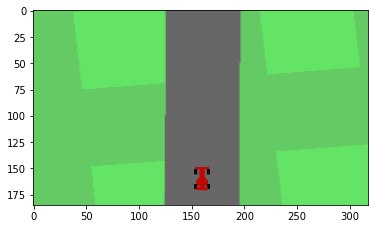

In [12]:
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

In [13]:
### Segmentation with Thresholding

In [14]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# initialize the list of threshold methods
methods = [
	("THRESH_BINARY", cv2.THRESH_BINARY),
	("THRESH_BINARY_INV", cv2.THRESH_BINARY_INV),
	("THRESH_TRUNC", cv2.THRESH_TRUNC),
	("THRESH_TOZERO", cv2.THRESH_TOZERO),
	("THRESH_TOZERO_INV", cv2.THRESH_TOZERO_INV)]
# loop over the threshold methods
for (threshName, threshMethod) in methods:
	# threshold the image and show it
	(T, thresh) = cv2.threshold(gray, 128, 255, threshMethod) ##128 default threshold value
	cv2.imshow(threshName, thresh)
	cv2.waitKey(0)

In [15]:
### Segmentation using Color spaces

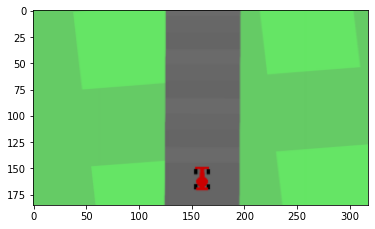

In [65]:
#colour_seg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [66]:
hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

In [77]:
light_red = (0,0,0)
dark_red = (255,255,255)

In [78]:
mask = cv2.inRange(hsv_img, light_red, dark_red)

In [79]:
print(mask)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [69]:
result = cv2.bitwise_and(image, image, mask = mask)

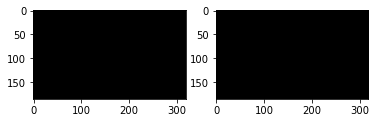

In [71]:
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

In [53]:
light_white = (0, 0, 200)
dark_white = (145, 60, 255)

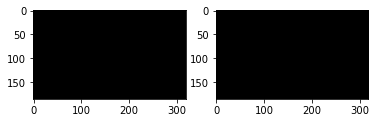

In [72]:
mask_white = cv2.inRange(hsv_img, light_white, dark_white)
result_white = cv2.bitwise_and(image, image, mask=mask_white)

plt.subplot(1, 2, 1)
plt.imshow(mask_white, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_white)
plt.show()

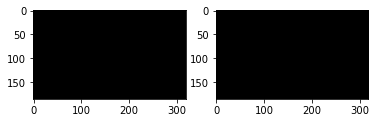

In [73]:
final_mask = mask + mask_white

final_result = cv2.bitwise_and(image, image, mask=final_mask)
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()